1. 파일 업로드

In [1]:
from google.colab import files
uploaded = files.upload()

import io, json
import pandas as pd

file_name = list(uploaded.keys())[0]
data = [json.loads(line) for line in io.StringIO(uploaded[file_name].decode('utf-8'))]
df = pd.DataFrame(data)
df.head()

Saving politifact_factcheck_data.json to politifact_factcheck_data.json


,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...


# 2. 전처리

2-1. Binary Labeling 및 특정 라벨 제외

In [2]:

# Binary Labeling
real_labels = ["true", "mostly-true"]
fake_labels = ["false", "pants-fire", "barely-true"]

#'half-true'제외
df_filtered = df[~df["verdict"].isin(["half-true", "mostly-false"])].copy()

# binary label
df_filtered["label"] = df_filtered["verdict"].apply(lambda x: 1 if x in fake_labels else 0)

# label distribution
df_filtered["label"].value_counts()


,count
label,
1,8328
0,5795


In [3]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered["label"], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df["label"], random_state=42)
print(len(train_df), len(val_df), len(test_df))

11298 1412 1413


2-2. 문장 임베딩

In [4]:
from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device='cuda')

X_bert_train = sbert.encode(train_df['statement'].tolist(), show_progress_bar=False)
X_bert_val = sbert.encode(val_df['statement'].tolist(), show_progress_bar=False)
X_bert_test = sbert.encode(test_df['statement'].tolist(), show_progress_bar=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2-3. 연도 추가 (baseline)

In [6]:
train_df['statement_year'] = train_df['statement_date'].str.split('/').str[-1]
val_df['statement_year'] = val_df['statement_date'].str.split('/').str[-1]
test_df['statement_year'] = test_df['statement_date'].str.split('/').str[-1]


2-4. 감성 점수 feature

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm
import os
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model.eval()
model = model.to('cuda')

def get_sentiment_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    return scores
# 감성 점수
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model.eval()
model = model.to('cuda')

def get_sentiment_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    return scores


train_df[['sent_neg', 'sent_neu', 'sent_pos']] = np.array([get_sentiment_scores(text) for text in tqdm(train_df['statement'], disable=True)])
val_df[['sent_neg', 'sent_neu', 'sent_pos']] = np.array([get_sentiment_scores(text) for text in tqdm(val_df['statement'], disable=True)])
test_df[['sent_neg', 'sent_neu', 'sent_pos']] = np.array([get_sentiment_scores(text) for text in tqdm(test_df['statement'], disable=True)])


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

2-5. TF-IDF 클러스터 거리


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

tfidf_vec = TfidfVectorizer(max_features=1000)
X_tfidf_train = tfidf_vec.fit_transform(train_df['statement'])
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_tfidf_train)
train_labels = kmeans.predict(X_tfidf_train)
_, train_dists = pairwise_distances_argmin_min(X_tfidf_train, kmeans.cluster_centers_)

X_tfidf_val = tfidf_vec.transform(val_df['statement'])
val_labels = kmeans.predict(X_tfidf_val)
_, val_dists = pairwise_distances_argmin_min(X_tfidf_val, kmeans.cluster_centers_)

X_tfidf_test = tfidf_vec.transform(test_df['statement'])
test_labels = kmeans.predict(X_tfidf_test)
_, test_dists = pairwise_distances_argmin_min(X_tfidf_test, kmeans.cluster_centers_)

train_df['tfidf_cluster_dist'] = train_dists
val_df['tfidf_cluster_dist'] = val_dists
test_df['tfidf_cluster_dist'] = test_dists

2-6. 문체 + NER

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")
train_df['num_entities'] = [len(nlp(text).ents) for text in tqdm(train_df['statement'], desc="NER Train", disable=True)]
val_df['num_entities'] = [len(nlp(text).ents) for text in tqdm(val_df['statement'], desc="NER Val", disable=True)]
test_df['num_entities'] = [len(nlp(text).ents) for text in tqdm(test_df['statement'], desc="NER Test", disable=True)]


train_df['word_count'] = train_df['statement'].apply(lambda x: len(x.split()))
val_df['word_count'] = val_df['statement'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['statement'].apply(lambda x: len(x.split()))


2-7. Method 1: BM25

In [10]:
!pip install rank_bm25

In [11]:
from rank_bm25 import BM25Okapi
from transformers import BertTokenizer, BertModel
import os
from transformers import logging
os.environ["TRANSFORMERS_NO_TQDM"] = "1"  # transformers progress bar 제거
logging.set_verbosity_error()


train_df['statement_source'] = train_df['statement_source'].fillna('')
train_df['statement_originator'] = train_df['statement_originator'].fillna('')
retrieval_corpus = train_df.apply(lambda row: f"{row['statement_source']} {row['statement_originator']}", axis=1).tolist()
tokenized_corpus = [doc.split(" ") for doc in retrieval_corpus]
bm25 = BM25Okapi(tokenized_corpus)

def enrich_statement(statement, n=3):
    query = statement.split()
    retrieved = bm25.get_top_n(query, retrieval_corpus, n=n)
    return statement + " " + " ".join(retrieved)

train_df['enriched_text'] = train_df['statement'].apply(enrich_statement)
val_df['enriched_text'] = val_df['statement'].apply(enrich_statement)
test_df['enriched_text'] = test_df['statement'].apply(enrich_statement)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval().to('cuda')

def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_vecs = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(cls_vecs)
    return np.array(embeddings)

X_bm_train = get_bert_embeddings(train_df['enriched_text'].tolist())
X_bm_val = get_bert_embeddings(val_df['enriched_text'].tolist())
X_bm_test = get_bert_embeddings(test_df['enriched_text'].tolist())


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

2-8. Method 3: 발화자 평균 신뢰도


In [12]:
N = 5
frequent_originators = train_df["statement_originator"].value_counts() >= N
# frequent_originators.sum().item()

top_k = 300

top_k_train_originators = (
    train_df['statement_originator']
    .value_counts()
    .nlargest(top_k)
    .index
    .tolist()
)

def group_originators(originator):
    return originator if originator in top_k_train_originators else "other"

train_df['originator_grouped'] = train_df['statement_originator'].apply(group_originators)
val_df['originator_grouped'] = val_df['statement_originator'].apply(group_originators)
test_df['originator_grouped'] = test_df['statement_originator'].apply(group_originators)

truth_map = train_df.groupby('statement_originator')['label'].mean()
global_mean = train_df['label'].mean()

train_df['originator_avg_truth'] = train_df['statement_originator'].map(truth_map).fillna(global_mean)
val_df['originator_avg_truth'] = val_df['statement_originator'].map(truth_map).fillna(global_mean)
test_df['originator_avg_truth'] = test_df['statement_originator'].map(truth_map).fillna(global_mean)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

originator_ids_train = le.fit_transform(train_df['originator_grouped'])
originator_ids_val = le.transform(val_df['originator_grouped'])
originator_ids_test = le.transform(test_df['originator_grouped'])

Encode, scale, one-hot, feature 결합

In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

bert_scaler = StandardScaler()
X_bert_train = bert_scaler.fit_transform(X_bert_train)
X_bert_val = bert_scaler.transform(X_bert_val)
X_bert_test = bert_scaler.transform(X_bert_test)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_src_train = encoder.fit_transform(train_df[['statement_source']])
X_src_val = encoder.transform(val_df[['statement_source']])
X_src_test = encoder.transform(test_df[['statement_source']])

year_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_year_train = year_encoder.fit_transform(train_df[['statement_year']])
X_year_val = year_encoder.transform(val_df[['statement_year']])
X_year_test = year_encoder.transform(test_df[['statement_year']])

style_cols = ['word_count', 'num_entities']
scaler = StandardScaler()
X_style_train = scaler.fit_transform(train_df[style_cols])
X_style_val = scaler.transform(val_df[style_cols])
X_style_test = scaler.transform(test_df[style_cols])

X_sent_train = scaler.fit_transform(train_df[['sent_neg', 'sent_neu', 'sent_pos']])
X_sent_val = scaler.transform(val_df[['sent_neg', 'sent_neu', 'sent_pos']])
X_sent_test = scaler.transform(test_df[['sent_neg', 'sent_neu', 'sent_pos']])

X_clust_train = scaler.fit_transform(train_df[['tfidf_cluster_dist']])
X_clust_val = scaler.transform(val_df[['tfidf_cluster_dist']])
X_clust_test = scaler.transform(test_df[['tfidf_cluster_dist']])

bm_scaler = StandardScaler()
X_bm_train_scaled = bm_scaler.fit_transform(X_bm_train)
X_bm_val_scaled = bm_scaler.transform(X_bm_val)
X_bm_test_scaled = bm_scaler.transform(X_bm_test)


import numpy as np
originator_ids_train_2d = originator_ids_train.reshape(-1, 1)
originator_ids_val_2d = originator_ids_val.reshape(-1, 1)
originator_ids_test_2d = originator_ids_test.reshape(-1, 1)


X_train_final = np.hstack([X_bert_train, X_sent_train, X_src_train, X_style_train, X_clust_train, X_year_train, originator_ids_train_2d, X_bm_train_scaled])
X_val_final = np.hstack([X_bert_val, X_sent_val, X_src_val, X_style_val, X_clust_val, X_year_val, originator_ids_val_2d, X_bm_val_scaled])
X_test_final = np.hstack([X_bert_test, X_sent_test, X_src_test, X_style_test, X_clust_test, X_year_test, originator_ids_test_2d, X_bm_test_scaled])
y_train_final = train_df['label'].values
y_val_final = val_df['label'].values
y_test_final = test_df['label'].values

# 3. MLP 모델

3-1. PyTorch 학습

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_final, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_final, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_final, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_final, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
import torch.nn as nn
class MLPBatchNorm1D(nn.Module):
    def __init__(self, input_dim, dropout_ratios):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[0]),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[1]),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[2]),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

DROPOUT_RATIOS = [0.5, 0.4, 0.3]
model = MLPBatchNorm1D(X_train_tensor.shape[1], DROPOUT_RATIOS)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 학습 루프
NUM_EPOCHS = 30
best_loss = float('inf')
best_model = None
early_stop = 5
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    train_losses = []
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    valid_losses = []
    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            valid_losses.append(loss.item())

    test_losses = []
    model.eval()
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            test_losses.append(loss.item())

    avg_valid_loss = np.mean(valid_losses)
    avg_test_loss = np.mean(test_losses)
    print(f"Epoch {epoch+1} | Train Loss: {np.mean(train_losses):.4f} | Valid Loss: {avg_valid_loss:.4f} | Test loss: {avg_test_loss}")

    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model = model
        epochs_no_improve = 0
        print("  --> Best model updated")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop:
            print("  --> Early stopping triggered")
            break



Epoch 1 | Train Loss: 0.5487 | Valid Loss: 0.5059 | Test loss: 0.5016520567562269
  --> Best model updated
Epoch 2 | Train Loss: 0.4997 | Valid Loss: 0.5011 | Test loss: 0.4901903945466746
  --> Best model updated
Epoch 3 | Train Loss: 0.4816 | Valid Loss: 0.5093 | Test loss: 0.48845644748729206
  --> Best model updated
Epoch 4 | Train Loss: 0.4650 | Valid Loss: 0.5113 | Test loss: 0.48928214415259985
Epoch 5 | Train Loss: 0.4405 | Valid Loss: 0.5155 | Test loss: 0.48870697358380194
Epoch 6 | Train Loss: 0.4271 | Valid Loss: 0.5222 | Test loss: 0.5009376944407172
Epoch 7 | Train Loss: 0.4083 | Valid Loss: 0.5374 | Test loss: 0.5068614547667296
Epoch 8 | Train Loss: 0.3942 | Valid Loss: 0.5400 | Test loss: 0.5065107812052188
  --> Early stopping triggered


# 4. 평가

classification report

In [ ]:
from sklearn.metrics import classification_report
best_model.eval()
with torch.no_grad():
    test_preds = best_model(X_test_tensor).round().squeeze()

print(classification_report(y_test_tensor, test_preds))


              precision    recall  f1-score   support

         0.0       0.66      0.79      0.72       580
         1.0       0.83      0.72      0.77       833

    accuracy                           0.75      1413
   macro avg       0.75      0.75      0.75      1413
weighted avg       0.76      0.75      0.75      1413



AUROC

[*] MLP Final | AP = 0.884, AUROC = 0.826
--------------------------------------------------


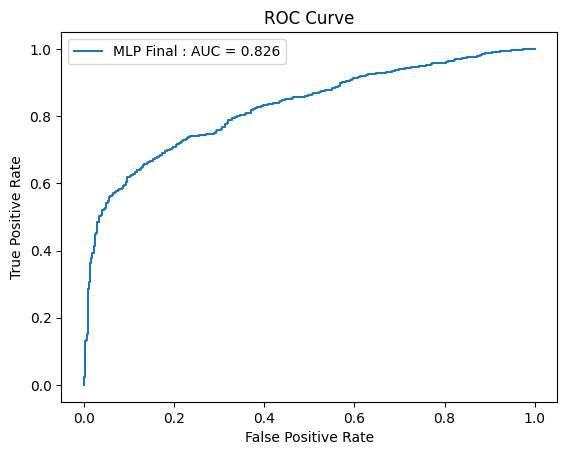

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

def evaluate_ap_and_auroc(test_labels, test_preds, exp_names):
    assert len(test_labels) == len(test_preds) == len(exp_names), "길이 불일치 오류"
    for labels, preds, exp_name in zip(test_labels, test_preds, exp_names):
        fpr, tpr, _ = roc_curve(labels, preds)
        auc = roc_auc_score(labels, preds)
        ap = average_precision_score(labels, preds)
        plt.plot(fpr, tpr, label=f'{exp_name} : AUC = {auc:.3f}')
        print(f"[*] {exp_name} | AP = {ap:.3f}, AUROC = {auc:.3f}")
    print("-" * 50)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

#  테스트셋 예측 확률값
best_model.eval()
with torch.no_grad():
    test_probs = best_model(X_test_tensor).squeeze().cpu().numpy()  # 확률값


exp_names = ['MLP Final']
test_preds = [test_probs]
test_labels = [y_test_tensor.cpu().numpy()]

evaluate_ap_and_auroc(test_labels, test_preds, exp_names)


# 5. 모델 저장

In [ ]:
np.save('final_test_probs.npy', best_model(X_test_tensor).detach().cpu().numpy())


In [ ]:
torch.save(best_model.state_dict(), "best_model.pt")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import torch
import os

save_path = "/content/drive/MyDrive/fakenews_results"
os.makedirs(save_path, exist_ok=True)

np.save(f"{save_path}/final_test_probs.npy", best_model(X_test_tensor).detach().cpu().numpy())

# 모델 가중치 저장
torch.save(best_model.state_dict(), f"{save_path}/best_model.pt")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/fakenews_results
